# One-dimensional packed-bed, catalytic-membrane reactor model without streamwise diffusion

The present model simulates heterogeneous catalytic processes inside packed-bed, catalytic membrane reactors. The gas-phase and surface-phase species conservation equations are derived and the system of differential-algebraic equations (DAE) is solved using the scikits.odes.dae IDA solver.

In [1]:
# Import Cantera and scikits
import numpy as np
from scikits.odes import dae
import cantera as ct
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]
print("Runnning Cantera version: " + ct.__version__)

Runnning Cantera version: 2.6.0


## Methodology

One-dimensional, steady-state catalytic-membrane reactor model with surface chemistry is developed to analyze species profiles along the length of a packed-bed, catalytic membrane reactor. The same model can further be simplified to simulate a simple packed-bed reactor by excluding the membrane. The example here demonstrates the one-dimensional reactor model explained by G. Kogekar, et al., "Efficient and robust computational models of  heterogeneous catalysis in catalytic membrane reactors," (2022), In preparation [1].

### Governing equations

Assuming steady-state, one-dimensional flow within the packed bed, total-mass, species mass and energy conservation may be stated as [2]

$$
    \frac{d(\rho u)}{dz} = \sum_{k=1}^{K_{\mathrm{g}}} \dot {s}_k W_k A_{\mathrm{s}} + \frac{P_{\mathrm b}}{A_{\mathrm b}}       j_{k_{\mathrm M}}, \\
    \rho u \frac{dY_k}{dz} + A_{\mathrm{s}} Y_k \sum_{k=1}^{K_{\mathrm{g}}} \dot {s}_k W_k  =  A_{\mathrm s} \dot {s}_k W_k    + \delta_{k, k_{\mathrm M}} \frac{P_{\mathrm b}}{A_{\mathrm b}} j_{k_{\mathrm M}}, \\
    \rho u c_{\mathrm p} \frac{dT}{dz} + \sum_{k=1}^{K_{\mathrm g}} h_k (\phi_{\mathrm g} \dot {\omega}_k +  A_{\mathrm s} \dot {s}_k) W_k = \hat h \frac{P_{\mathrm b}}{A_{\mathrm b}}(T_{\mathrm w} - T) + \delta_{k, k_{\mathrm M}} \frac{P_{\mathrm b}}{A_{\mathrm b}} h_{k_{\rm M}}  j_{k_{\mathrm M}}.
$$

The fractional coverages of the $K_{\rm s}$ surface adsorbates $\theta_k$ must satisfy 
$$
    \dot {s}_k = 0,     {\ \ \ \ \ \ } (k = 1,\ldots, K_{\mathrm s}),
$$
which, at steady state, requires no net production/consumption of surface species by the heterogeneous reactions [3].

The pressure within the bed is calculated as
$$ 
    \frac{dp}{dz} = - \left( \frac{\phi_{\mathrm{g}} \mu}{\beta_{\mathrm{g}}} \right) u,
$$
where $\mu$ is the gas-phase mixture viscosity. The packed-bed permeability $\beta_{\rm g}$ is evaluated using the Kozeny-Carman relationship as 
$$
    \beta_{\mathrm g} = \frac{\phi_{\mathrm{g}}^3 D_{\mathrm p}^2}{72 \tau_{\mathrm{g}}(1 - \phi_{\mathrm{g}})^2},
$$
where $\phi_{\mathrm{g}}$, $\tau_{\mathrm{g}}$, and $D_{\mathrm {p}}$ are the bed porosity, tortuosity, and particle diameter, respectively.

The independent variable in these conservation equations is the position $z$ along the reactor length. The dependent variables include total mass flux $\rho u$, pressure $p$, temperature $T$, gas-phase mass fractions $Y_k$, and surfaces coverages $\theta_k$. Gas-phase fluxes through the membrane are represented as $j_{k, {\mathrm M}}$. Geometric parameters $A_{\mathrm s}$, $P_{\mathrm b}$, and $A_{\mathrm b}$ represent the catalyst specific surface area (dimensions of surface area per unit volume), reactor perimeter, and reactor cross-sectional flow area, respectively. Other parameters include bed porosity $\phi_{\mathrm g}$ and gas-phase species molecular weights $W_k$. The gas density $\rho$ is evaluated using the equation of state (ideal Eos, RK or PR EoS).

If a perm-selective membrane is present, then $j_{k_{\mathrm M}}$ represents the gas-phase flux through the membrane and ${k_{\mathrm M}}$ is the gas-phase species that permeates through the membrane. The Kronecker delta, $\delta_{k, k_{\mathrm M}} = 1$ for the membrane-permeable species and  $\delta_{k, k_{\mathrm M}} = 0$ otherwise. The membrane flux is calculated using Sievert's law as
$$
    {j_{k_{\mathrm M}}}^{\text{Mem}} = \frac{B_{k_{\mathrm M}}}{t} \left ( p_{k_{\mathrm M} {\text{, mem}}}^\alpha - p_{k_{\mathrm M} \text{, sweep}}^\alpha \right ) W_{k_{\rm M}}
$$
where $B_{k_{\mathrm M}}$ is the membrane permeability, $t$ is the membrane thickness. $p_{k_{\mathrm M} \text{, mem}}$ and $p_{k_{\mathrm M} \text{, sweep}}$ represent perm-selective species partial pressures within the packed-bed and the exterior sweep channel. The present model takes the pressure exponent $\alpha$ to be unity. The membrane flux for all other species ($ k \neq k_{\mathrm M}$) is zero.

### Chemistry mechanism
This example uses a detailed 12-step elementary micro-kinetic reaction mechanism that describes ammonia formation and decomposition kinetics over the Ru/Ba-YSZ catalyst. The reaction mechanism is developed and validated using measured performance in a laboratory-scale packed-bed reactor [4]. This example also incorporates a Pd-based H<sub>2</sub> perm-selective membrane.


### Solver

Above governing equations represent a complete solution for a steady-state packed-bed, catalytic membrane reactor model. The dependent variables are the mass-flux $\rho u$, species mass-fractions $Y_k$, pressure $p$, temperature $T$, and surface coverages $\theta_k$. The equation of state is used to obtain the mass density, $\rho$.

The governing equations form an initial value problem (IVP) in a differential-algebraic (DAE) form as follows:
$$
   f(z,{\bf{y}}, \bf {y'}, c) = 0,
$$
where $\bf{y}$ and $\bf{y'}$ represent the solution vector and its derivative vector, respectively. All other constants such as reference temperature, chemical constants, etc. are incorporated in vector $c$ (Refer to [5] for more details). This type of DAE system in this example is solved using the `scikits.odes.dae` IDA solver.
> 1. G. Kogekar, H. Zhu, R.J. Kee, 'Efficient and robust computational models of  heterogeneous catalysis in catalytic membrane reactors', (2022), In preparation
> 2. B. Kee, C. Karakaya, H. Zhu, S. DeCaluwe, and R.J. Kee, 'The Influence of Hydrogen-Permeable Membranes and Pressure on Methane Dehydroaromatization in Packed-Bed Catalytic Reactors', Industrial & Engineering Chemistry Research (2017) 56, 13:3551 - 3559
> 3. R.J. Kee, M.E. Coltrin, P. Glarborg, and H. Zhu, 'Chemically Reacting Flow: Theory, Modeling and Simulation', Wiley (2018)
> 4. Z. Zhang, C. Karakaya, R.J. Kee, J. Douglas Way, C. Wolden,, 'Barium-Promoted Ruthenium Catalysts on Yittria-Stabilized Zirconia Supports for Ammonia Synthesis', ACS Sustainable Chemistry & Engineering (2019) 7:18038 - 18047
> 5. G. Kogekar, 'Computationally efficient and robust models of non-ideal thermodynamics, gas-phase kinetics and heterogeneous catalysis in chemical reactors' (2021), Doctoral dissertation. 

### Define gas-phase and surface-phase species

In [2]:
# Import the reaction mechanism for Ammonia synthesis/decomposition on Ru-Ba/YSZ catalyst
mechfile = "data/Ammonia-Ru-Ba-YSZ.yaml"
# Import the models for gas-phase
gas = ct.Solution(mechfile, "gas")
# Import the model for surface-phase
surf = ct.Interface(mechfile, "Ru_surface", [gas])

# Other parameters
n_gas = gas.n_species  # number of gas species
n_surf = surf.n_species  # number of surface species
n_gas_reactions = gas.n_reactions  # number of gas-phase reactions

# Set offsets of dependent variables in the solution vector
offset_rhou = 0
offset_p = 1
offset_T = 2
offset_Y = 3
offset_Z = offset_Y + n_gas
n_var = offset_Z + n_surf  # total number of variables (rhou, P, T, Yk and Zk)

print("Number of gas-phase species = ", n_gas)
print("Number of surface-phase species = ", n_surf)
print("Number of variables = ", n_var)

Number of gas-phase species =  4
Number of surface-phase species =  6
Number of variables =  13


### Define reactor geometry and operating conditions

In [3]:
# Reactor geometry
L = 5e-2  # length of the reactor (m)
R = 5e-3  # radius of the reactor channel (m)
phi = 0.5  # porosity of the bed (-)
tau = 2.0  # tortuosity of the bed (-)
dp = 3.37e-4  # particle diameter (m)
As = 3.5e6  # specific surface area (1/m)

# Energy (adiabatic or isothermal)
solve_energy = True  # True: Adiabatic, False: isothermal

# Membrane (True: membrane, False: no membrane)
membrane_present = True
membrane_perm = 1e-15  # membrane permeability (kmol*m3/s/Pa)
thickness = 3e-6  # membrane thickness (m)
membrane_sp_name = "H2"  # membrane-permeable species name
p_sweep = 1e5  # partial pressure of permeable species in the sweep channel (Pa)
permeance = membrane_perm / thickness  # permeance of the membrane (kmol*m2/s/Pa)

if membrane_present:
    print("Modeling packed-bed, catalytic-membrane reactor...")
    print(membrane_sp_name, "permeable membrane is present.")

# Get required properties based on the geometry and mechanism
W_g = gas.molecular_weights  # vector of molecular weight of gas species
vol_ratio = phi / (1 - phi)
eff_factor = phi / tau  # effective factor for permeability calculation
# permeability based on Kozeny-Carman equation
B_g = B_g = vol_ratio**2 * dp**2 * eff_factor / 72  
area2vol = 2 / R  # area to volume ratio assuming a cylindrical reactor
D_h = 2 * R  # hydraulic diameter
membrane_sp_ind = gas.species_index(membrane_sp_name)

# Inlet operating conditions
T_in = 673  # inlet temperature [K]
p_in = 5e5  # inlet pressure [Pa]
v_in = 0.001  # inlet velocity [m/s]
T_wall = 723  # wall temperature [K]
h_coeff = 1e2  # heat transfer coefficient [W/m2/K]

# Set gas and surface states
gas.TPX = T_in, p_in, "NH3:0.99, AR:0.01"  # inlet composition
surf.TP = T_in, p_in
Yk_0 = gas.Y
rhou0 = gas.density * v_in

# Initial surface coverages
# advancing coverages over a long period of time to get the steady state.
surf.advance_coverages(1e10)  
Zk_0 = surf.coverages

Modeling packed-bed, catalytic-membrane reactor...
H2 permeable membrane is present.


### Define residual function required for IDA solver

In [4]:
def residual(z, y, yPrime, res):
    """Solution vector for the model
    y = [rho*u, p, T, Yk, Zk]
    yPrime = [d(rho*u)dz, dpdz, dTdz, dYkdz, dZkdz]
    """
    # Get current thermodynamic state from solution vector and save it to local variables.
    rhou = y[offset_rhou]  # mass flux (density * velocity)
    Y = y[offset_Y : offset_Y + n_gas]  # vector of mass fractions
    Z = y[offset_Z : offset_Z + n_surf] # vector of site fractions 
    p = y[offset_p]  # pressure
    T = y[offset_T]  # temperature

    # Get derivatives of dependent variables
    drhoudz = yPrime[offset_rhou]  
    dYdz = yPrime[offset_Y : offset_Y + n_gas] 
    dZdz = yPrime[offset_Z : offset_Z + n_surf] 
    dpdz = yPrime[offset_p]  
    dTdz = yPrime[offset_T] 

    # Set current thermodynamic state for the gas and surface phases
    # Note: use unnormalized mass fractions and site fractions to avoid over-constraining the system
    gas.set_unnormalized_mass_fractions(Y)
    gas.TP = T, p
    surf.set_unnormalized_coverages(Z)
    surf.TP = T, p

    # Calculate required variables based on the current state
    coverages = surf.coverages  # surface site coverages
    # heterogeneous production rate of gas species
    sdot_g = surf.get_net_production_rates("gas")
    # heterogeneous production rate of surface species
    sdot_s = surf.get_net_production_rates("Ru_surface")
    wdot_g = np.zeros(n_gas)
    # specific heat of the mixture
    cp = gas.cp_mass  
    # partial enthalpies of gas species
    hk_g = gas.partial_molar_enthalpies  

    if n_gas_reactions > 0:
        # homogeneous production rate of gas species
        wdot_g = gas.net_production_rates  
    mu = gas.viscosity  # viscosity of the gas-phase

    # Calculate density using equation of state
    rho = gas.density

    # Calculate flux term through the membrane
    # partial pressure of membrane-permeable species
    memsp_pres = (p * gas.X[membrane_sp_ind]) 
    # negative sign indicates the flux going out
    membrane_flux = (-permeance * (memsp_pres - p_sweep) / W_g[membrane_sp_ind])  

    # Conservation of total-mass
    # temporary variable
    sum_continuity = As * np.sum(sdot_g * W_g) + phi * np.sum(wdot_g * W_g)  
    res[offset_rhou] = (drhoudz - sum_continuity - area2vol * membrane_flux * membrane_present)

    # Conservation of gas-phase species        
    res[offset_Y:offset_Y+ n_gas] = (dYdz + (Y * sum_continuity - phi * np.multiply(wdot_g,W_g) 
                                     - As * np.multiply(sdot_g,W_g)) / rhou)
    res[offset_Y + membrane_sp_ind] -= area2vol * membrane_flux * membrane_present

    # Conservation of site fractions (algebraic contraints in this example)
    res[offset_Z : offset_Z + n_surf] = sdot_s

    # For the species with largest site coverage (k_large), solve the constraint equation: sum(Zk) = 1
    # The residual function for 'k_large' would be 'res[k_large] = 1 - sum(Zk)'
    # Note that here sum(Zk) will be the sum of coverages for all surface species, including the 'k_large' species.
    ind_large = np.argmax(coverages)
    res[offset_Z + ind_large] = 1 - np.sum(coverages)

    # Conservation of momentum
    u = rhou / rho
    res[offset_p] = dpdz + phi * mu * u / B_g

    # Conservation of energy
    res[offset_T] = dTdz - 0  # isothermal condition
    # Note: One can just not solve the energy equation by keeping temperature constant. 
    # But since 'T' is used as the dependent variable, the residual is res[T] = dTdz - 0 
    # One can also write res[T] = 0 directly, but that leads to a solver failure due to singular jacobian

    if solve_energy:
        conv_term = (4 / D_h) * h_coeff * (T_wall - T) * (2 * np.pi * R)
        chem_term = np.sum(hk_g * (phi * wdot_g + As * sdot_g))
        res[offset_T] -= (conv_term - chem_term) / (rhou * cp)

### Calculate the spatial derivatives at the inlet that will be used as the initial conditions for the IDA solver


In [5]:
# Initialize yPrime to 0 and call residual to get initial derivatives
y0 = np.hstack((rhou0, p_in, T_in, Yk_0, Zk_0))
yprime0 = np.zeros(n_var)
res = np.zeros(n_var)
residual(0, y0, yprime0, res)
yprime0 = -res

### Solve the system of DAEs using ida solver

In [6]:
solver = dae(
    "ida",
    residual,
    first_step_size=1e-15,
    atol=1e-14,  # absolute tolerance for solution
    rtol=1e-06,  # relative tolerance for solution
    algebraic_vars_idx=[np.arange(offset_Y + n_gas, offset_Z + n_surf, 1)],
    max_steps=8000,
    one_step_compute=True,
    old_api=False,  # forces use of new api (namedtuple)
)

distance = []
solution = []
state = solver.init_step(0.0, y0, yprime0)

# Note that here the variable t is an internal varible used in scikits. In this example, it represents
# the natural variable z, which corresponds to the axial distance inside the reactor.
while state.values.t < L:
    distance.append(state.values.t)
    solution.append(state.values.y)
    state = solver.step(L)

distance = np.array(distance)
solution = np.array(solution)
print(state)

SolverReturn(flag=<StatusEnumIDA.SUCCESS: 0>, values=SolverVariables(t=0.05008188075110137, y=array([1.40862546e-03, 4.99997977e+05, 6.85053268e+02, 8.87695903e-02,
       4.76156874e-01, 4.11794146e-01, 2.31457254e-02, 3.31389994e-03,
       9.93036016e-01, 2.72895231e-03, 8.58521045e-04, 3.67135998e-08,
       6.25735914e-05]), ydot=array([-1.00712547e-02, -4.63384892e+01,  2.35197310e+01,  1.93773529e+00,
       -1.09694323e+01,  9.02163101e+00, -4.93684753e-06,  1.65140796e-01,
       -3.26729842e-01,  1.54845328e-01,  5.55655962e-03,  4.81233014e-07,
        1.18667692e-03])), errors=SolverVariables(t=None, y=None, ydot=None), roots=SolverVariables(t=None, y=None, ydot=None), tstop=SolverVariables(t=None, y=None, ydot=None), message='Successful function return.')


### Plot results

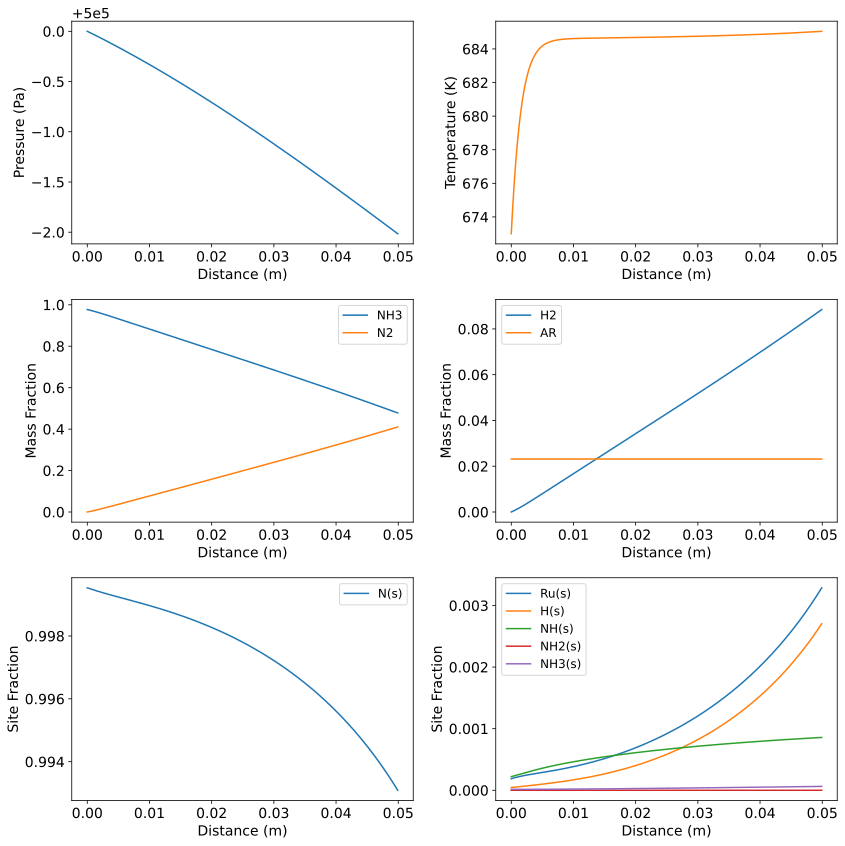

In [7]:
plt.rcParams["font.size"] = 14
f, ax = plt.subplots(3, 2, figsize=(12, 12), dpi=96)

# Plot gas pressure profile along the flow direction
ax[0, 0].plot(distance, solution[:, offset_p], color="C0")
ax[0, 0].set_xlabel("Distance (m)")
ax[0, 0].set_ylabel("Pressure (Pa)")

# Plot gas temperature profile along the flow direction
ax[0, 1].plot(distance, solution[:, offset_T], color="C1")
ax[0, 1].set_xlabel("Distance (m)")
ax[0, 1].set_ylabel("Temperature (K)")

# Plot major and minor gas species separately
minor_idx = []
major_idx = []
for j, name in enumerate(gas.species_names):
    mean = np.mean(solution[:, offset_Y + j])
    if mean <= 0.1:
        minor_idx.append(j)
    else:
        major_idx.append(j)

# Plot mass fractions of the gas-phase species along the flow direction

# Major gas-phase species
for j in major_idx:
    ax[1, 0].plot(distance, solution[:, offset_Y + j], label=gas.species_names[j])
ax[1, 0].legend(fontsize=12, loc="best")
ax[1, 0].set_xlabel("Distance (m)")
ax[1, 0].set_ylabel("Mass Fraction")

# Minor gas-phase species
for j in minor_idx:
    ax[1, 1].plot(distance, solution[:, offset_Y + j], label=gas.species_names[j])
ax[1, 1].legend(fontsize=12, loc="best")
ax[1, 1].set_xlabel("Distance (m)")
ax[1, 1].set_ylabel("Mass Fraction")

# Plot major and minor surface species separately
minor_idx = []
major_idx = []
for j, name in enumerate(surf.species_names):
    mean = np.mean(solution[:, offset_Z + j])
    if mean <= 0.1:
        minor_idx.append(j)
    else:
        major_idx.append(j)

# Plot the site fraction of the surface-phase species along the flow direction
# Major surf-phase species
for j in major_idx:
    ax[2, 0].plot(distance, solution[:, offset_Z + j], label=surf.species_names[j])
ax[2, 0].legend(fontsize=12, loc="best")
ax[2, 0].set_xlabel("Distance (m)")
ax[2, 0].set_ylabel("Site Fraction")

# Minor surf-phase species
for j in minor_idx:
    ax[2, 1].plot(distance, solution[:, offset_Z + j], label=surf.species_names[j])
ax[2, 1].legend(fontsize=12, loc="best")
ax[2, 1].set_xlabel("Distance (m)")
ax[2, 1].set_ylabel("Site Fraction")
f.tight_layout()